In [1]:
import numpy as np
import h5py
import matplotlib.pylab as plt
import sys
import sigpy
sys.path.append('../../../src/')

# custom scripts
import mri_cs
import helpers
from undersampling import radial_sampling
from helpers import calculate_metrics, get_proportion, zero_fill

from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

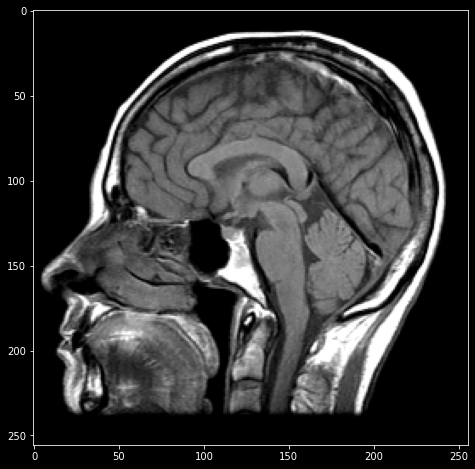

In [2]:
img_file = '../../../data/head.png'

import imageio
img = np.array(imageio.imread(img_file), dtype="float64")
img = img[::4, ::4]
head = img.copy()

rows, cols = head.shape

_ = plt.imshow(np.abs(head), cmap="gray")

0.176422119140625

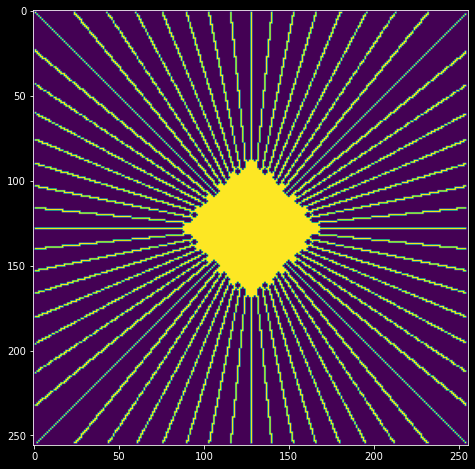

In [3]:
radial_mask = np.fft.fftshift(radial_sampling(rows, cols, 64, dilations=0))
samples_rows = np.where(radial_mask.flatten())[0]
b = np.fft.fft2(head).flatten()[samples_rows]

get_proportion(head.flatten(), b)
_ = plt.imshow(np.fft.fftshift(radial_mask))

In [4]:
import scipy
def to_matlab(var, var_name: str):
    var = {var_name: var}
    scipy.io.savemat(var_name + ".mat", var)
        
def from_matlab(filename: str) -> np.ndarray:
    return scipy.io.loadmat(filename)

to_matlab(head, "head")
to_matlab(b, "b")
to_matlab(samples_rows, "samples_rows")

PSNR: 23.938319149769427
SSIM: 0.5535236859490037
SNR: 13.422161272759851
MSE: 388.3821477868896


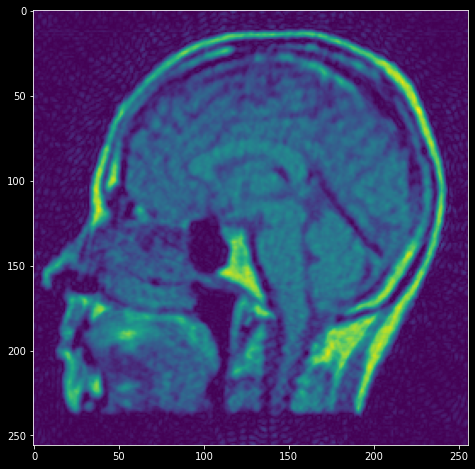

In [5]:
zero_filled = zero_fill(b, samples_rows, rows, cols)

_ = plt.imshow(np.abs(zero_filled))
_ = calculate_metrics(np.abs(head), np.abs(zero_filled))

# No prior information LP minimization

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 34.268070697784424s
PSNR: 26.25555564194474
SSIM: 0.7202833339828992
SNR: 15.498546779264677
MSE: 240.780165397073


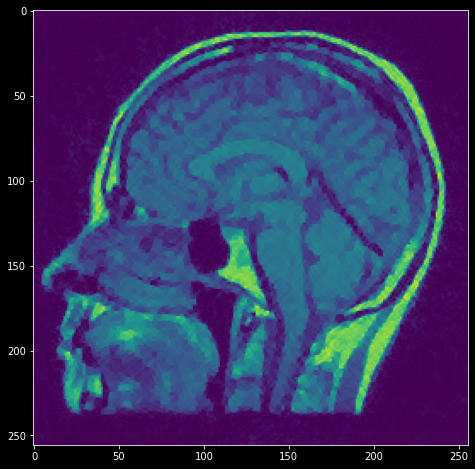

In [6]:
import mri_cs
reload(mri_cs)

filters = [[[1.0, -1.0], [1.0, -1.0]],
            [[1.0, 1.0], [-1.0, -1.0]],
            [[1.0, -1.0], [-1.0, 1.0]]]
rows, cols = head.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30

nopi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                                 p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                                 number_jobs=1, maxiterperstage=maxiterperstage,
                                 verbose=False)

_ = plt.imshow(np.abs(nopi_recon))
_ = calculate_metrics(np.abs(head), np.abs(nopi_recon))

# Visualizing prior information leveraged

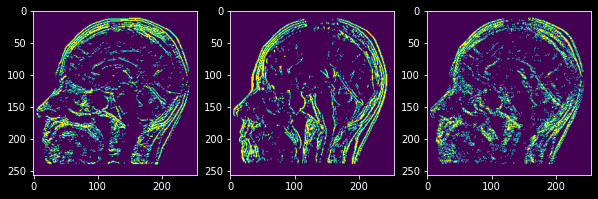

In [7]:
phi = mri_cs.prior_information(np.abs(head), pi_prop=13/100, filters=filters)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
_ = ax1.imshow(helpers.create_mask(phi[0]))
_ = ax2.imshow(helpers.create_mask(phi[1]))
_ = ax3.imshow(helpers.create_mask(phi[2]))

# LP Minimization with pre filtering and prior information

<module 'mri_cs' from '../../../src/mri_cs.py'>

####### Reconstructing filtered image 1 of 3 #######
####### Reconstructing filtered image 2 of 3 #######
####### Reconstructing filtered image 3 of 3 #######
Prefiltering elapsed time: 57.90083837509155s
PSNR: 28.804279785157632
SSIM: 0.8368472575461993
SNR: 18.41328974788899
MSE: 123.0683595245107


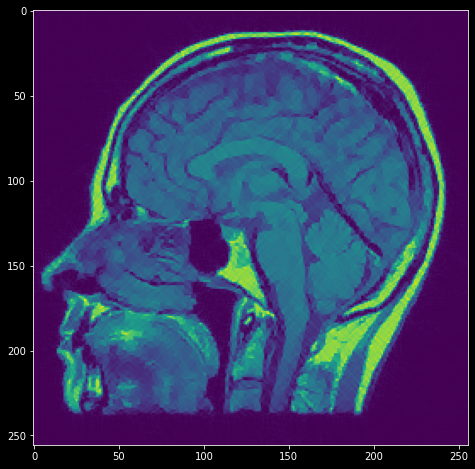

In [8]:
import mri_cs
reload(mri_cs)

rows, cols = head.shape
tol_cg = 1e-3
maxiter_cg = 2 * b.size
maxiterperstage = 30
tau = 1e-1

pi_recon = mri_cs.prefiltering(samples_rows, b, rows, cols, h=filters, 
                               p=1, tol_cg=tol_cg, maxiter_cg=maxiter_cg, 
                               number_jobs=1, maxiterperstage=maxiterperstage,
                               phi=phi, tau=tau, verbose=False)

_ = plt.imshow(np.abs(pi_recon))
_ = calculate_metrics(np.abs(head), np.abs(pi_recon))